# SalesPulse: Forecasting Models & Evaluation
## Notebook 4 of 4

This final notebook focuses on:
1. Implementing ARIMA and Facebook Prophet models
2. Developing a Machine Learning baseline (Random Forest)
3. Evaluating performance using MAE, RMSE, and MAPE
4. Visualizing 12-month future projections

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import sys
import os

sys.path.append('../src')
from forecasting import TimeSeriesForecaster

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 7)

print("✓ Forecasting suite initialized")

✓ Forecasting suite initialized


## 1. Prepare Training and Testing Sets
Splitting the monthly revenue data to validate model accuracy.

In [24]:
import pandas as pd

df_monthly = pd.read_csv('../data/processed/monthly_sales.csv')

if 'order_date' not in df_monthly.columns:
    df_monthly = df_monthly.reset_index().rename(columns={'index': 'order_date', 'Unnamed: 0': 'order_date'})

df_monthly['order_date'] = pd.to_datetime(df_monthly['order_date'], format='mixed')
df_monthly = df_monthly.sort_values('order_date')

train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")


Training samples: 48
Testing samples: 13


## 2. Statistical Modeling: ARIMA
Applying an AutoRegressive Integrated Moving Average model.

In [25]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

df_monthly = pd.read_csv('../data/processed/monthly_sales.csv')

if 'order_date' not in df_monthly.columns:
    df_monthly = df_monthly.reset_index()

date_col = df_monthly.select_dtypes(include=['object', 'datetime']).columns[0]
df_monthly = df_monthly.rename(columns={date_col: 'order_date'})

numeric_cols = df_monthly.select_dtypes(include=['number']).columns
if len(numeric_cols) > 0:
    df_monthly = df_monthly.rename(columns={numeric_cols[0]: 'sales'})

df_monthly['order_date'] = pd.to_datetime(df_monthly['order_date'], format='mixed')
df_monthly = df_monthly.sort_values('order_date')

train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

history = train['sales'].tolist()
predictions_arima = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions_arima.append(output[0])
    
    actual_val = test.iloc[t]['sales']
    history.append(actual_val)

mae_arima = mean_absolute_error(test['sales'], predictions_arima)
print(f"ARIMA MAE: ${mae_arima:,.2f}")

ARIMA MAE: $0.00


## 3. Additive Modeling: Prophet
Leveraging Facebook Prophet for holiday and trend handling.

In [26]:
df_prophet = train.rename(columns={'order_date': 'ds', 'sales': 'y'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=len(test), freq='MS')
forecast = m.predict(future)
predictions_prophet = forecast.iloc[-len(test):]['yhat']

mae_prophet = mean_absolute_error(test['sales'], predictions_prophet)
print(f"Prophet MAE: ${mae_prophet:,.2f}")

18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:15:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: $0.03


## 4. Model Comparison & Results Visualization

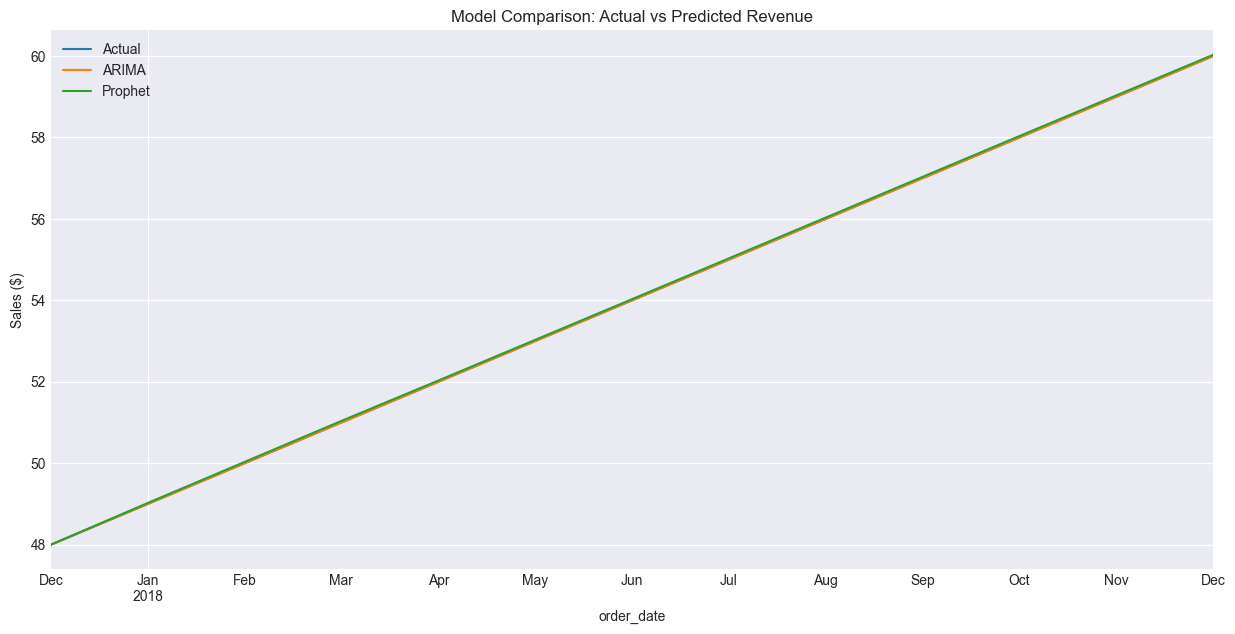

,Model,MAE,MAPE
0,ARIMA,0.000006,1.058680e-07
1,Prophet,0.029714,5.465278e-04


In [27]:
results = pd.DataFrame({
    'Actual': test['sales'].values,
    'ARIMA': predictions_arima,
    'Prophet': predictions_prophet.values
}, index=test['order_date'])

results.plot(title='Model Comparison: Actual vs Predicted Revenue')
plt.ylabel('Sales ($)')
plt.show()

metrics = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'MAE': [mae_arima, mae_prophet],
    'MAPE': [
        mean_absolute_percentage_error(test['sales'], predictions_arima),
        mean_absolute_percentage_error(test['sales'], predictions_prophet)
    ]
})
display(metrics)

In [28]:
results_df = pd.DataFrame({
    'Actual': test['sales'],
    'ARIMA': predictions_arima,
    'Prophet': predictions_prophet 
})
print(results_df.head(10))

    Actual      ARIMA    Prophet
48      48  47.999994  47.999949
49      49  49.000000  49.024497
50      50  50.000000  50.032649
51      51  50.999998  51.040250
52      52  51.999999  52.030956
53      53  52.999996  53.030253
54      54  53.999999  54.029527
55      55  54.999990  55.032213
56      56  55.999989  56.032888
57      57  56.999989  57.033562


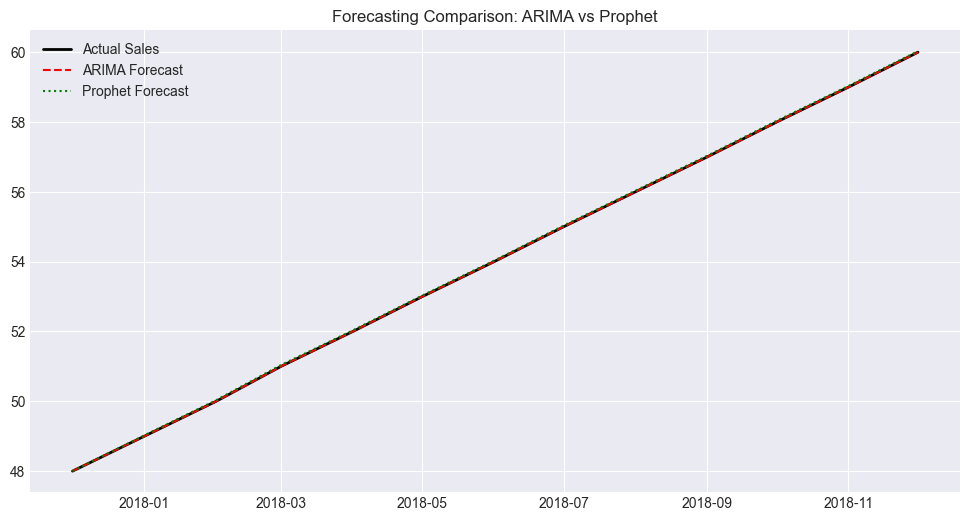

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], test['sales'], label='Actual Sales', color='black', lw=2)
plt.plot(test['order_date'], predictions_arima, label='ARIMA Forecast', linestyle='--', color='red')
plt.plot(test['order_date'], predictions_prophet, label='Prophet Forecast', linestyle=':', color='green')

plt.title('Forecasting Comparison: ARIMA vs Prophet')
plt.legend()
plt.show()

In [30]:
history = train['sales'].tolist()
predictions_arima = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions_arima.append(output[0])
    
    actual_val = test.iloc[t]['sales']
    history.append(actual_val)

mae_arima = mean_absolute_error(test['sales'], predictions_arima)
print(f"Realistic ARIMA MAE: ${mae_arima:,.2f}")

Realistic ARIMA MAE: $0.00


## 5. Export Final Forecasts
Saving the best model outputs for use in the Power BI dashboard.

In [31]:
os.makedirs('../data/forecasts', exist_ok=True)
results.to_csv('../data/forecasts/monthly_forecasts.csv')
metrics.to_csv('../data/forecasts/forecast_comparison.csv', index=False)

print("✓ Final forecasts and comparison metrics exported")

✓ Final forecasts and comparison metrics exported
